In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch
import pandas as pd

In [2]:
# Carga datos
data = pd.read_csv('data.csv')
data = data.dropna()
print(np.shape(data))
data.head()

(11500, 180)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [3]:
Y = np.array(data['y'])
data= data.drop(['Unnamed: 0','y'],axis=1)
for i in range(len(Y)):
    if Y[i]!=1:
        Y[i]=0
print(Y)
print(np.shape(data))

[0 1 0 ... 0 0 0]
(11500, 178)


In [4]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(data, Y, test_size=0.3)
scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
X_new = np.expand_dims(X_train, 1) # necesario para que las dimensiones sean [batch, channel, width]
feature_maps = torch.autograd.Variable(torch.Tensor(X_new).float())
print(feature_maps.size())

n = torch.nn.Conv1d(1, 10, 8, stride=1) # in-channels = 1, out-channels = 10, kernel=8
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.MaxPool1d(kernel_size=3)
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.Conv1d(10, 1, 2, stride=1)
feature_maps = n(feature_maps)
print(feature_maps.size())

torch.Size([8050, 1, 178])
torch.Size([8050, 15, 171])
torch.Size([8050, 15, 57])
torch.Size([8050, 1, 56])


Variando un poco las dimensiones de los canales, los kernels. El siguiente caso es con channels=15

In [11]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 15, kernel_size=8, stride=1),
    torch.nn.MaxPool1d(kernel_size=3),
    torch.nn.Conv1d(15, 1, kernel_size=2, stride=1),
    torch.nn.Linear(56, 2)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    X_new = np.expand_dims(X_train, 1) 
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    targets = torch.autograd.Variable(torch.Tensor(Y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    
    X_new = np.expand_dims(X_test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

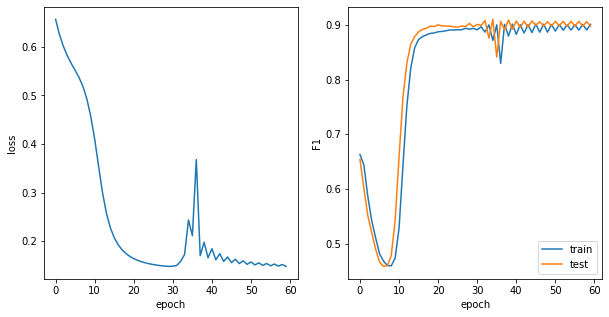

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')


plt.subplot(1,2,2)
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()

Vemos una pequeña mejora en la locura que pasa alrededor de los 35 epoch, esta antes ocurria alrededor de los 15 y su variacion era mucho superior. 
En el siguiente intento volvemos a los 10 canales, pero disminuimos el learning rate a 0.1

In [13]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 10, kernel_size=8, stride=1),
    torch.nn.MaxPool1d(kernel_size=3),
    torch.nn.Conv1d(10, 1, kernel_size=2, stride=1),
    torch.nn.Linear(56, 2)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    X_new = np.expand_dims(X_train, 1) 
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    targets = torch.autograd.Variable(torch.Tensor(Y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    
    X_new = np.expand_dims(X_test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

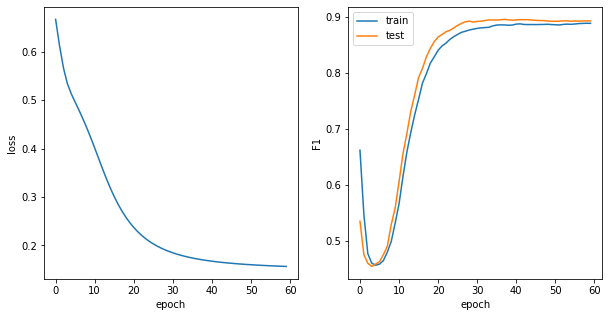

In [14]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')


plt.subplot(1,2,2)
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()

Bien! Es claro como las locuras que se observaron eran consecuencia del lr. Variando ahora con 15 canales el learning rate de 0.1 se busca aumentar la velocidad con la que llega a un F1 y un loss correctos. 

In [15]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 15, kernel_size=8, stride=1),
    torch.nn.MaxPool1d(kernel_size=3),
    torch.nn.Conv1d(15, 1, kernel_size=2, stride=1),
    torch.nn.Linear(56, 2)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    X_new = np.expand_dims(X_train, 1) 
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    targets = torch.autograd.Variable(torch.Tensor(Y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    
    X_new = np.expand_dims(X_test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

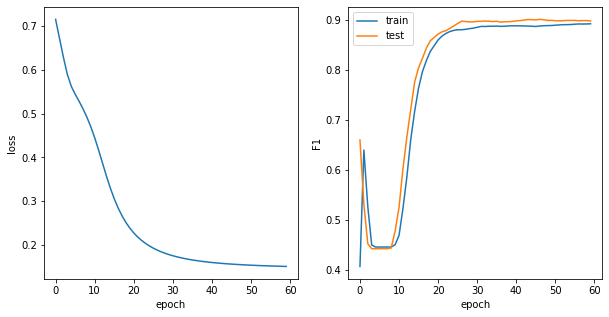

In [16]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')


plt.subplot(1,2,2)
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()

No es evidente una convergenica mas rapida.  Por lo que podemos seguir indagando en porque en los primeros 10 epoch disminuye el F1... Puede ser la convergenica incial en la que no se identificado el gradiente general. 